# Biodiversity Intactness Decline in Phoenix, AZ

### Author: Joshua Paul Cohen

All code and associated files can be found in this repository: https://github.com/silkieMoth/thomas-fire-aftermath-and-BII

## About

### Purpose

Biodiversity Intactness Index (BII) is a measure of quantifying biodiversity in an exosystem and is, in a general sence, calculated by: 

$$ \frac{\text{Species Richness}}{\text{Area of Undisturbed Land}} $$

More specifically, the index considers species richness of a given taxonomic group with in the context of a given ecosystem, relative to the amount and type of human land use within given ecosystem, relative to a reference ecosystem of expected healthy conditions (Scholes & Briggs, 2005).

The desert ecosystem is one that is particularly sensitive to human disturbance, as the arid abiotic conditions result in biotic factors occuring over especially long time scales (Guo, 2004). Furthermore, an integral component of the desert ecosystem's function, cryptobiotic crust, can be destroyed by people merely stepping where they shouldn't (Belnap & Eldridge, 2001). Recreational areas often impose strict rules for where people are and are not allowed to explore to preserve this keystone component of the biome.

Despite this, Phoenix, AZ, a major and densily populated metropolitan area in the Sonoran Desert, has experienced a significant amount of urban sprawl and suburban development within the past several decades. Such development has likely resulted in significant decreases in BII within the local regions, and possibly affected neighboring and distant regions as well. 

The goal of this notebook therefore, is to attempt to quantify the decrease in Biodiversity Intactness within the district of Phoenix AZ. This is accomplished by crossreferencing BII rasters from two years (2017 and 2020), and ascertaining the difference between them.

### Highlights 

* Interfacing with Microsoft's Planetary Computer API to import the BII rasters.
    + Utilized the `planetary_computer` and `pystac_client` packages to fetch items from the `io-biodiversity` collection.
* Clipping of rasters to the US Census Bureau's shapefile polygon for the district of Phoenix.
* Calculating percentage of area within Phoenix with a BII greater than 0.75.
    + Accomplished by first calculating cell size.
* Creation of raster highlighting areas with greater than 0.75 BII loss from 2017 to 2020
    1. Created boolean rasters for if cells are greater than 0.75.
    2. Use `XOR` function to get all cells that are greater than 0.75 in 2017 but not 2020

### Data Descriptions

* `io-biodiversity` is a set of 100m rasters created by the geospatial monitoring and analysis organizations Impact Observatory and Vizzuality. It documents the BII of ecosystems around the world and is the culmination of 750 studies. It contains 4 rasters for each year between 2017 and 2020, although only the 2017 and 2020 raster's are called in this analysis.
* The US Census Bureau's `TIGER/Line Shapefile, 2021, State, Arizona, County Subdivisions` contains polygons for all county boundaries within Arizona. Each polygon contains: 
    + A series of FIPS codes and GEOID associated with that boundary
    + A name.
    + A series of legal codes describing the boundary.
    + A code describing functional status.
    + Area calculations for land and water (in degrees).
    + The latitude/longitude of the center point.

### Citations:

#### **In-text**:
Scholes, R., Biggs, R. A biodiversity intactness index. *Nature* 434, 45–49 (2005). https://doi.org/10.1038/nature03289

Guo, Q. (2004). Slow recovery in desert perennial vegetation following prolonged human disturbance. *Journal of Vegetation Science*, 15(6), 757–762. https://doi.org/10.1111/j.1654-1103.2004.tb02318.x

Belnap, J., & Eldridge, D. (2001). Disturbance and recovery of biological soil crusts. *In Biological soil crusts: structure, function, and management* (pp. 363-383). Berlin, Heidelberg: Springer Berlin Heidelberg. 

"County and City Data Book: 2007" (PDF) (14 ed.). U.S. Census Bureau. 2007. p. 712. Archived from the original (PDF) on January 16, 2016. Retrieved March 19, 2016. </br>
#### **Data**:
Impact Observatory, Vizzuality (2022). *io-biodiversity* (v1) [Dataset]. Microsoft Planetary Computer STAC Catalog. https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview

Department of Commerce. (2021). *TIGER/Line Shapefile, 2021, State, Arizona, County Subdivisions* [Dataset]. U.S. Census Bureau. https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-arizona-county-subdivisions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import os
import contextily as cx
from shapely.geometry import Polygon
import xarray as xr
import rasterio
import rasterio.mask
import salem
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images

# Create file paths to base and data
root = os.path.join('/', 'Users', 'jpcohen', 'EDS-220', 'thomas-fire-aftermath-and-BII')
az_fp = os.path.join(root, 'data', 'tl_2021_04_cousub', 'tl_2021_04_cousub.shp')

az = gpd.read_file(az_fp)

# Subset district shapefile for phoenix
phoenix = az[az['NAME'] == 'Phoenix']

## Accessing `io-biodiversity` Data

Rather than downloading and importing as a file, we interface with the Planetary Computer STAC Collection API. The STAC structure is that where a catalog contains a series of collections containing a series of items. In this case, we are accessing the `io-biodiversity` collection, then querying for the 2017 and 2020 rasters within it, at a given extent.

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Get BII collection
bio_collection = catalog.get_child('io-biodiversity')

# Establish dimension ranges for our item subset
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 33.863574],
            [-112.826843, 32.974108],
            [-111.184387, 32.974108],
            [-111.184387, 33.863574],
            [-112.826843, 33.863574]
        ]
    ],
}

time_range = '2017/2020'

# Fetch just BII items for 2017 and 2020
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = [-112.826843, 32.974108, -111.184387, 33.863574],
    datetime = time_range,
    ids = ["bii_2020_34.74464974521749_-115.38597824385106_cog", 
           "bii_2017_34.74464974521749_-115.38597824385106_cog"])

# Get retrieved items
items = search.item_collection()

# Place 2017 and 2020 assets into individual variables
bio_2020 = items[0]
bio_2017 = items[1]

## Preliminary Data Exploration

The `io-biodiversity` items contains assets for a rendered preview, a tilejson, and the data itself. Both rendered previews appear to be very similar upon first inspection. When the items are opened as a dataArray, they have the standard 4 dimensions (`band`, `x`, `y`, `spatial_ref`), with `band` being length 1. They both share x,y lengths of 7992 x 7992, a total of 63872064 values, and CRS's of EPSG:4326.

The shapefile containing the Phoenix polygon has a different CRS of EPSG:4269.

In [3]:
print('BII 2017 assets: ', list(bio_2017.assets))
print('BII 2020 assets: ', list(bio_2020.assets))

BII 2017 assets:  ['data', 'tilejson', 'rendered_preview']
BII 2020 assets:  ['data', 'tilejson', 'rendered_preview']


In [4]:
# plot rendered preview
Image(url = bio_2017.assets['rendered_preview'].href, width = 500)

In [5]:
Image(url = bio_2020.assets['rendered_preview'].href, width = 500)

In [6]:
phoenix_2017_rast = rioxr.open_rasterio(bio_2017.assets['data'].href)
phoenix_2017_rast

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [7]:
phoenix_2020_rast = rioxr.open_rasterio(bio_2020.assets['data'].href)
phoenix_2020_rast

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [8]:
print(f'BII 2017 CRS: {phoenix_2017_rast.rio.crs}')
print(f'BII 2020 CRS: {phoenix_2020_rast.rio.crs} \n')
print('Phoenix shapefile CRS: ', phoenix.crs)

BII 2017 CRS: EPSG:4326
BII 2020 CRS: EPSG:4326 

Phoenix shapefile CRS:  epsg:4269


## The Geographic Context of The Broader Phoenix District

The area in question is the Phoenix-Mesa-Chandler Metropolitan Statistical District.

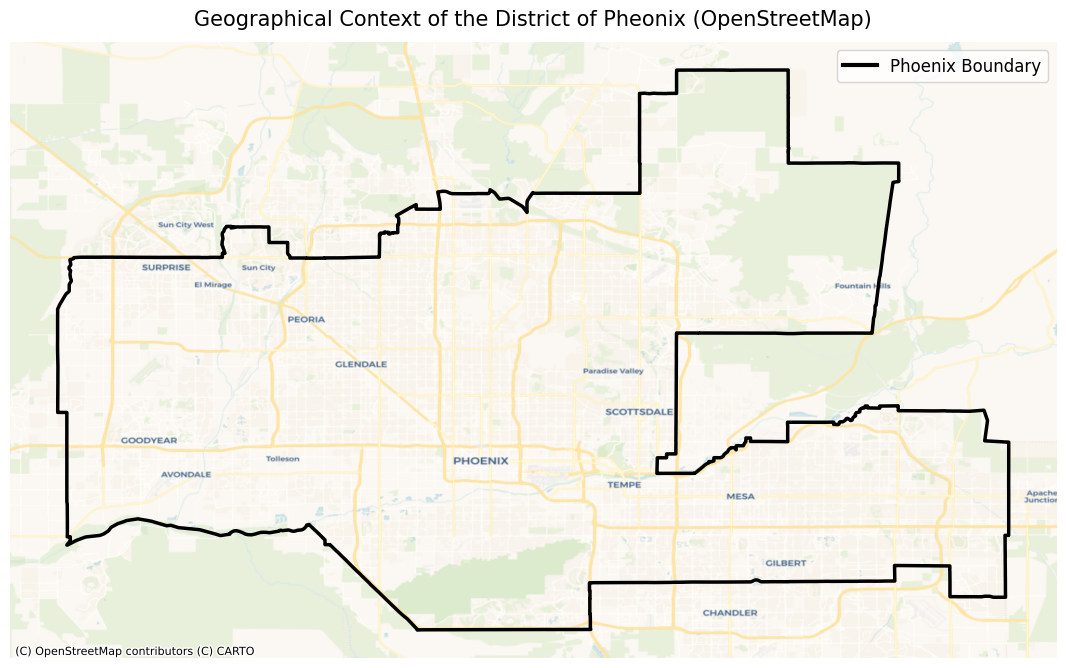

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('off')

# Phoenix polygon
phoenix.boundary.plot(ax = ax, alpha = 1, color = 'black', linewidth = 2.5)

# Legend for phoenix polygon
ax.legend(handles = [Line2D([0], [0], color='black', lw=3)], 
          labels = ['Phoenix Boundary'], 
          loc = 'best', 
          fontsize = 'large')

# Openstreetmap basemap
cx.add_basemap(ax = ax, 
               crs = phoenix.crs, 
               source = cx.providers.CartoDB.Voyager)

ax.set_title('Geographical Context of the District of Pheonix (OpenStreetMap)', fontsize = 15, pad = 12)

plt.show()

## Focusing Rasters on Phoenix

Because the extent of this analysis is Phoenix AZ, we can clip the rasters down to the shape of the AZ polygon from the TIGER shapefile. We use the `salem` package to accomplish this, which works with `rasterio` and `geopandas` in plotting, manipulation, and transformation of geospatial data.

In [10]:
# Remove length 1 band dimensions
phoenix_2017_rast = phoenix_2017_rast.squeeze().drop_vars('band')
phoenix_2020_rast = phoenix_2020_rast.squeeze().drop_vars('band')

In [11]:
# Clip rasters to extent of phoenix polygon
phoenix_2017_clip = phoenix_2017_rast.rio.clip_box(*phoenix.total_bounds).copy()
phoenix_2020_clip = phoenix_2020_rast.rio.clip_box(*phoenix.total_bounds).copy()

# Clip rasters to shape of polygon
phoenix_2017_rast_mask = phoenix_2017_clip.salem.roi(geometry = Polygon(*phoenix.geometry))
phoenix_2020_rast_mask = phoenix_2020_clip.salem.roi(geometry = Polygon(*phoenix.geometry))

## Obtaining Total Area of BII >= 0.75 within Phoenix

We can derive the area by getting cell size for each raster, and multiplying it by the number of cells within the Phoenix boundary.

In [12]:
# Calculate cell size for 2020
resolution_x_2020 = abs(phoenix_2020_rast_mask.x[1] - phoenix_2020_rast_mask.x[0])
resolution_y_2020 = abs(phoenix_2020_rast_mask.y[1] - phoenix_2020_rast_mask.y[0])

cell_size_2020 = resolution_x_2020 * resolution_y_2020

# Calculate cell sioze for 2017
resolution_x_2017 = abs(phoenix_2017_rast_mask.x[1] - phoenix_2017_rast_mask.x[0])
resolution_y_2017 = abs(phoenix_2017_rast_mask.y[1] - phoenix_2017_rast_mask.y[0])
 
cell_size_2017 = resolution_x_2017 * resolution_y_2017

# Total area of rasters
phoenix_2017_area = phoenix_2017_rast_mask.sum().item() * cell_size_2017
phoenix_2020_area = phoenix_2020_rast_mask.sum().item() * cell_size_2020

In [13]:
# Subset rasters for greater than 0.75 BII within phoenix
phoenix_2017_bii_75 = phoenix_2017_rast_mask.where((phoenix_2017_rast_mask >= 0.75) & (phoenix_2017_rast_mask != np.nan))
phoenix_2020_bii_75 = phoenix_2020_rast_mask.where((phoenix_2020_rast_mask >= 0.75) & (phoenix_2020_rast_mask != np.nan))

# Get area of subset
phoenix_2017_bii_75_area = phoenix_2017_bii_75.count() * cell_size_2017
phoenix_2020_bii_75_area = phoenix_2020_bii_75.count() * cell_size_2020

# Get percent of area that BII is greater than 0.75
phoenix_2017_pct_75 = (phoenix_2017_bii_75_area / phoenix_2017_area) * 100
phoenix_2020_pct_75 = (phoenix_2020_bii_75_area / phoenix_2020_area) * 100

In [14]:
[phoenix_2020_pct_75, phoenix_2017_pct_75]

[<xarray.DataArray ()>
 array(17.17745786)
 Coordinates:
     spatial_ref  int64 0,
 <xarray.DataArray ()>
 array(18.66693272)
 Coordinates:
     spatial_ref  int64 0]

## Projecting Areas of Greater Than 0.75 BII Loss in Phoenix-Mesa-Chandler MSD

Because our search is binary, we can create boolean rasters for all cells over or equal to 0.75, than compare them with an `XOR` operator. This gives us all areas where BII was 0.75 in 2017 but not in 2020.
* The limitation of this approach is that it also fetches all areas that are 0.75 in 2020 but not in 2017.


In [15]:
# Create boolean rasters
phoenix_2017_bit = phoenix_2017_rast_mask >= 0.75
phoenix_2020_bit = phoenix_2020_rast_mask >= 0.75

# Make cell true if BII is greater than 0.75 in 2017 but not in 2020
phoenix_diff = (phoenix_2017_bit ^ phoenix_2020_bit)

# Set all true, false equal to 1, nan respectively
phoenix_diff = xr.where(phoenix_diff == True, 1, np.nan)

In [16]:
# Comvert phoenix polygon crs to match rasters
phoenix = phoenix.to_crs(phoenix_2020_rast.rio.crs)

## Mapping the BII Loss

Text(0.5, 1.0, 'Area where BII loss exceeds 0.75 from 2017 to 2020 (Phoenix, AZ)')

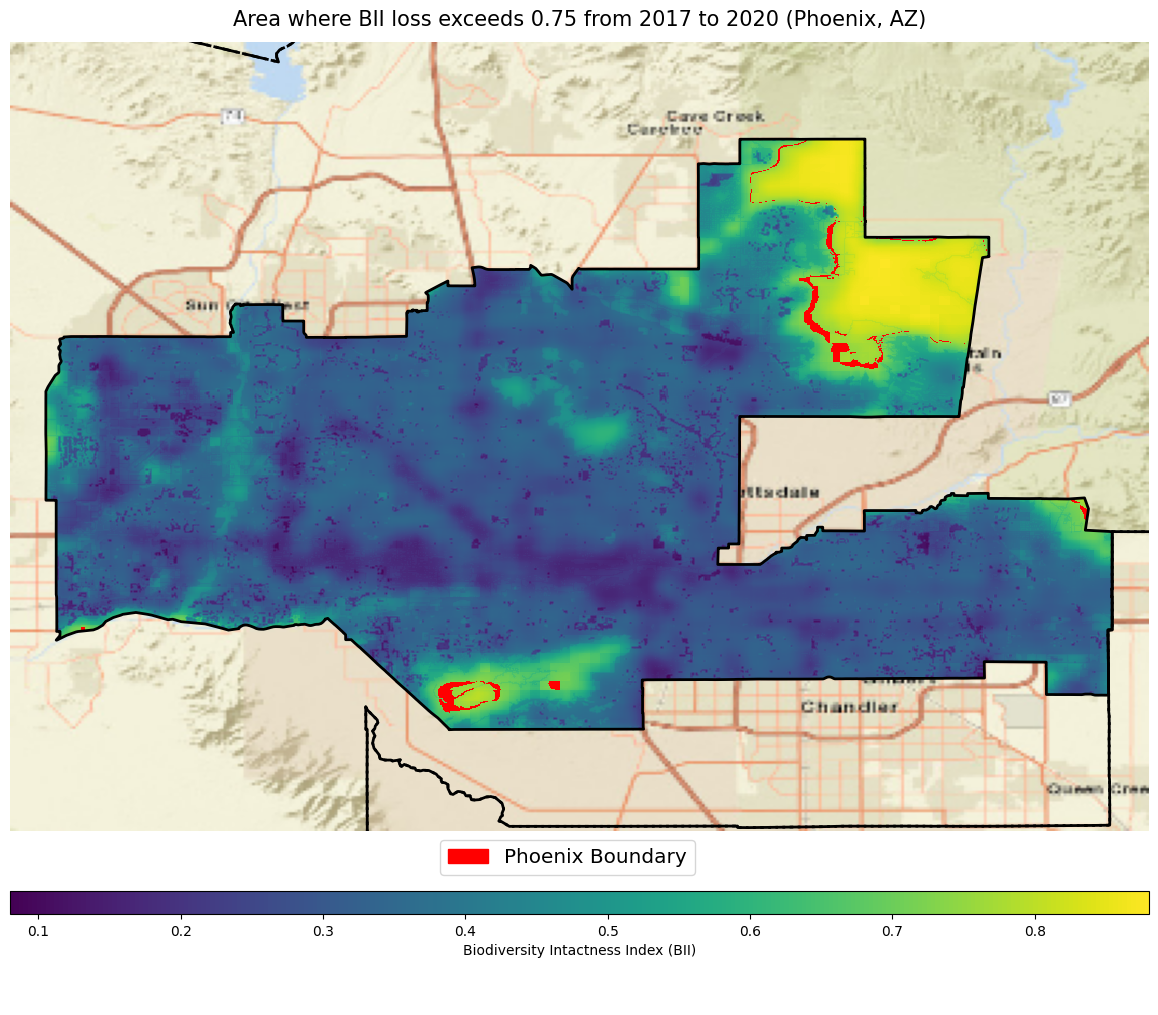

In [17]:
fig, ax = plt.subplots(figsize=(phoenix_2017_rast_mask.rio.width/67.5, 
                                phoenix_2017_rast_mask.rio.height/45))
ax.axis('off')

# Init mpl.toolkits basemap
bm = Basemap(projection='merc',
            resolution='c', llcrnrlon = -112.5, urcrnrlon = -111.55, llcrnrlat = 33.2, urcrnrlat = 33.9, epsg = 4269)

# County lines and basemap
bm.drawcounties(ax = ax, linewidth = 2, linestyle = '-.')
bm.arcgisimage(ax = ax, service = 'World_Street_Map')

# BII raster
bii = phoenix_2020_rast_mask.plot.imshow(ax=ax,
                                   cbar_kwargs = {'orientation': 'horizontal',
                                                  'pad': 0.06, 
                                                  'aspect': 50,
                                                  'label': 'Biodiversity Intactness Index (BII)'})

#leg_labels = [Patch(color = 'red', label = 'Areas where BII decreased below 0.75 between 2017 and 2020')]

fig.legend(handles = [Patch(color = 'red', label = 'Areas where BII decreased below 0.75 between 2017 and 2020')], 
          labels = ['Phoenix Boundary'], 
          loc = (0.38,0.138), 
          fontsize = 'x-large')


# Phoenix outline
phoenix.boundary.plot(ax = ax, alpha = 1, color = 'black', linewidth = 2)

# Areas of greater than 0.75 BII loss
phoenix_diff.plot.imshow(ax = ax,
                         colors = 'red',
                         levels = 2,
                         add_colorbar = False)

ax.set_title('Area where BII loss exceeds 0.75 from 2017 to 2020 (Phoenix, AZ)', fontsize = 15, pad = 12)

## BII Visualization Explanation

Analysis of BII in Phoenix, AZ as it changes from 2017 to 2020 suggests a thinning of biodiversity in the mountain ranges by the city. This occured within wilderness preserves close to the limits of the city and at the edges of BII hotspots suggesting a thinning from the sides of the ecosystem. 

A possible cause could be encroaching development and suburban sprawl, as Phoenix has expanded into many suburbs within the past 20 years. However, these preserves are also popular for recreation, and the desert exosystem is uniquely sensitive to disturbance, so it's possible human foot traffic may have played a role.